# Data Mining CISC873
Every three weeks we were given a new dataset to work on with our assigned prediction or clustering methods. I was assigned Support Vector Machines and Stacked Denoising Autoencoders for the semester. Each week we presented our resutls to the class. 

### Goal:
A telecommunications company finds that some of its customers leave
for other providers. They would like to understand if those who
leave ('churn') have particular properties, for two reasons: they
may be able to address issues that cause customers to leave, or
they may be able to offer customers who are about to leave some
kind of sweetener that will entice them to stay.
Your mission is to help develop this understanding using your allocated
technique.

Since the semester is over and I am not restricted to SVM and SDAE, I am going to try multiple prediction and clustering techniques with this dataset.

IIRC, this dataset is from IBM but we were given it in class without info. 
The full dataset will be included in this repository but it can also be found on Kaggle along with other notebooks - https://www.kaggle.com/blastchar/telco-customer-churn/kernels






In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, interp
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.svm import SVC, LinearSVC # "Support vector classifier"
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,accuracy_score, log_loss, roc_curve, auc,confusion_matrix
from itertools import cycle
import itertools
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import RFECV
%matplotlib inline
sns.set_style("whitegrid")

#### Importing & cleaning dataset

In [56]:
df_orig = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = pd.DataFrame(df_orig)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [57]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...  DeviceProtection  \
0  No phone service             DSL             No  ...                No   
1                No             DSL            Yes  ...               Yes   
2                No             DSL            Yes  ...                No   
3  No phone service             DSL            Yes  ...               Yes   
4                No     Fiber optic             No  ...                No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [58]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [59]:
df.describe()
# missing TotalCharges for 9 customers
# could drop or use mean TotalCharges -> replace with 0 because they are new customers 

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7032.000000
mean        0.162147    32.371149       64.761692   2283.300441
std         0.368612    24.559481       30.090047   2266.771362
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

First, I convert all categorical features to numeric and address missing data.
TotalCharges is missing data, after futher inspection it is clear that these customers are new to the company.
Although tenure * MonthlyCharges != TotalCharges, the customers missing TotalCharges have paid $0 in monthly charges and have been with the company for 0 months. Since the dataset is small I decided to impute these missing values rather than drop the rows. I think it is important to represent new customers in the dataset. 

In [60]:
print(df[['tenure', 'MonthlyCharges','TotalCharges','Contract']].head())

df[df.isnull().any(axis=1)]["tenure"]

# the people missing totalCharges values did not churn
# customers who have TotalCharges of 0 have also not finished a contract yet but do have monthlycharges data
# in row 1 you can see that they have only been a customer for one month
# 1889.50/56.95 = approx 33
# tenure is number of months they have been a customer


   tenure  MonthlyCharges  TotalCharges        Contract
0       1           29.85         29.85  Month-to-month
1      34           56.95       1889.50        One year
2       2           53.85        108.15  Month-to-month
3      45           42.30       1840.75        One year
4       2           70.70        151.65  Month-to-month


488     0
753     0
936     0
1082    0
1340    0
3331    0
3826    0
4380    0
5218    0
6670    0
6754    0
Name: tenure, dtype: int64

In [61]:
df.TotalCharges = df.TotalCharges.fillna(0)

Categorical -> Numeric <br>
Any feature with two values is converted to binary and any feature with more than two unique values is converted to one-hot encoding.

In [62]:
# enumerating categorical columns
categorical_columns = list(df.select_dtypes(exclude=np.number).columns)[1:]
for cat in categorical_columns:
    if len(df[cat].unique()) < 3:
        categorical_columns.remove(cat)
        if df[cat].str.contains('Yes').any():
            df[cat] = df[cat].eq('Yes').mul(1)

In [63]:
categorical_columns.remove('Partner')
# categorical columns with more than two possible values
df = pd.get_dummies(df, columns=categorical_columns)
df.gender = df.gender.eq('Female').mul(1)
df.Partner = df.Partner.eq('Yes').mul(1)

In [64]:
df.to_csv('churned_cleaned.csv')

In [65]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transf

Some observations from the graphs below
- There are more customers who have been with the company for less than 12 months than there are who have been with the company for 60-80 months.
- A large group of customers pay approx `$`25 per month while the rest pay between `$`50 and `$`125.


Some ideas to explore
- who pays more each month, new customers or old customers?
- which groups of customers are likely to churn?
- which features are important for predicting churning?
- can useful features be created from existing features?
- which features differ the most between customers who churn and customers who stay?


% Churn:  0.265
% Stay:  0.735


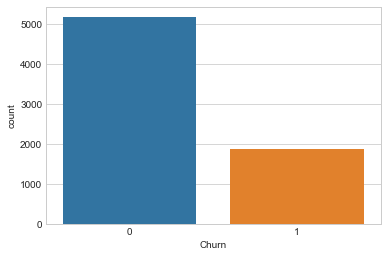

In [66]:
ax = sns.countplot(x="Churn", data=df)
rows = df.shape[0]
print("% Churn: ",round((df.Churn.sum()/rows),3))
print("% Stay: ",round((rows - df.Churn.sum())/rows,3))


% of customers who are senior citizens:  0.162


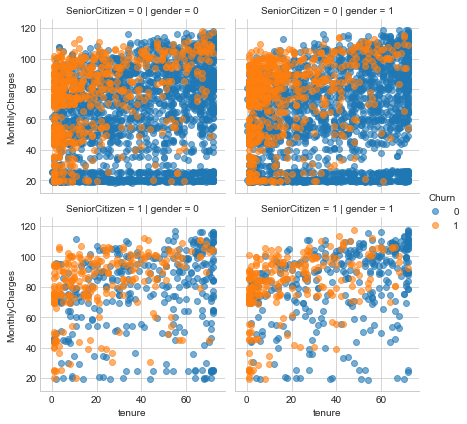

In [67]:
print("% of customers who are senior citizens: ", round(df.SeniorCitizen.sum()/df.shape[0],3))
g = sns.FacetGrid(df, row='SeniorCitizen', col="gender", hue="Churn")
g.map(plt.scatter, "tenure", "MonthlyCharges", alpha=0.6)
g.add_legend();

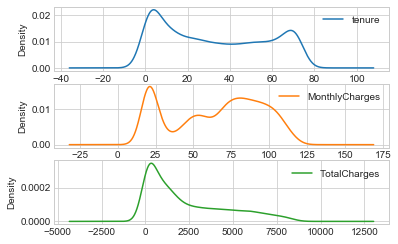

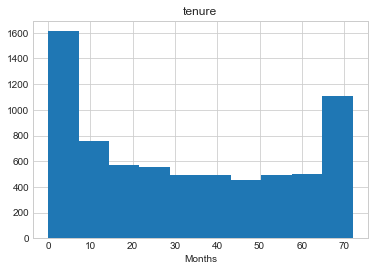

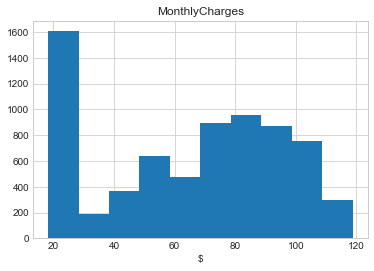

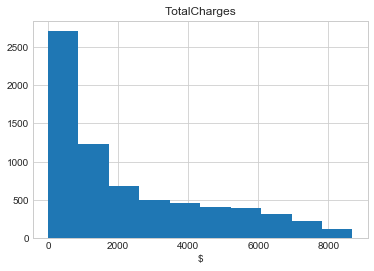

In [68]:
tograph = ["tenure","MonthlyCharges","TotalCharges"]
data = df[tograph]
data.plot(kind='density', subplots=True,  sharex=False)
plt.show()
df['tenure'].hist()
plt.title("tenure")
plt.xlabel("Months")
plt.show()
df['MonthlyCharges'].hist()
plt.title("MonthlyCharges")
plt.xlabel("$")
plt.show()
df['TotalCharges'].hist()
plt.title("TotalCharges")
plt.xlabel("$")
plt.show()

In [69]:
#check how many of each churn class
print("Churned: ", len(df[df["Churn"] == 1]))
print("Stayed: ", len(df[df["Churn"] == 0]))

Churned:  1869
Stayed:  5174


In [70]:
df_description = df.describe()
df_description[['tenure','MonthlyCharges','TotalCharges']]

tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000

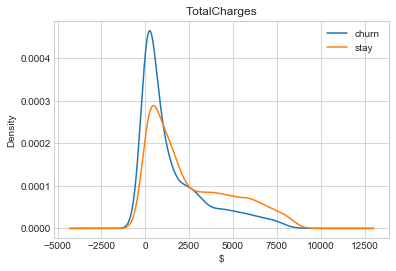

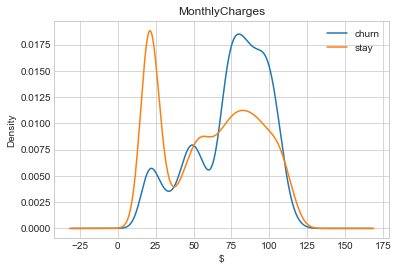

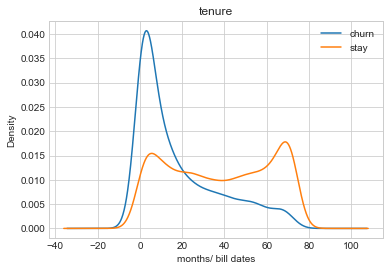

In [71]:
df_churn = df[df["Churn"]==1]
df_stay = df[df["Churn"]==0]
df_churn['TotalCharges'].plot(kind='density',label="churn")
df_stay['TotalCharges'].plot(kind='density',label="stay")
plt.title("TotalCharges")
plt.xlabel("$")
plt.legend()
plt.show()
df_churn['MonthlyCharges'].plot(kind='density',label="churn")
df_stay['MonthlyCharges'].plot(kind='density',label="stay")
plt.title("MonthlyCharges")
plt.xlabel("$")
plt.legend()
plt.show()
df_churn['tenure'].plot(kind='density',label="churn")
df_stay['tenure'].plot(kind='density',label="stay")
plt.title("tenure")
plt.xlabel("months/ bill dates")
plt.legend()
plt.show()

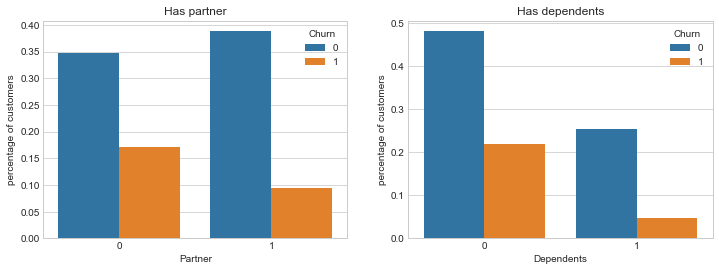

In [72]:
fig, axis = plt.subplots(1, 2, figsize=(12,4))
axis[0].set_title("Has partner")
axis[1].set_title("Has dependents")
axis_y = "percentage of customers"

# Plot Partner column
gp_partner = df.groupby('Partner')["Churn"].value_counts()/len(df)
gp_partner = gp_partner.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Partner', y= axis_y, hue='Churn', data=gp_partner, ax=axis[0])

# Plot Dependents column
gp_dep = df.groupby('Dependents')["Churn"].value_counts()/len(df)
gp_dep = gp_dep.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Dependents', y= axis_y, hue='Churn', data=gp_dep, ax=axis[1])

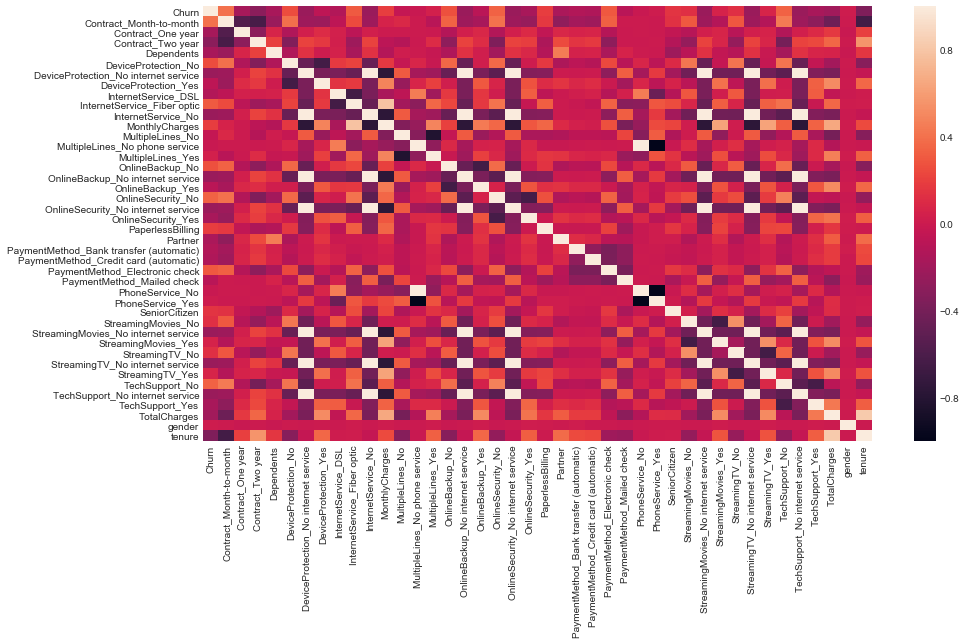

In [73]:
temp = df[df.columns.difference(['customerID'])]
corr = temp.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)



In [74]:
# #https://www.kaggle.com/jsaguiar/exploratory-analysis-with-seaborn
# def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):
#     ratios = pd.DataFrame()
#     g = df_orig.groupby(feature)["Churn"].value_counts().to_frame()
#     g = g.rename({"Churn": axis_name}, axis=1).reset_index()
#     g[axis_name] = g[axis_name]/len(df_orig)
#     if orient == 'v':
#         ax = sns.barplot(x=feature, y= axis_name, hue='Churn', data=g, orient=orient)
#         ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
#     else:
#         ax = sns.barplot(x= axis_name, y=feature, hue='Churn', data=g, orient=orient)
#         ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
#     ax.plot()
    
# barplot_percentages("SeniorCitizen")
# plt.figure(figsize=(9, 4.5))
# barplot_percentages("InternetService", orient="h")

- Customers who churn are have paid more during their time with the telecom company. 
- They are more people who churn that are paying about `$`


still need to show that fibre optic is an issue and people with more than 4 services are unlikely to churn

--------

Separating dataframe into X and y - scaling with StandardScaler

In [75]:
# not including churn or customer id
df["extra_fees"] = df.apply((lambda x: x.TotalCharges - (x.tenure*x.MonthlyCharges)),axis=1)
X = df[df.columns.difference(['Churn', 'customerID'])].values
y = df["Churn"].values
print("FULL")
print(X.shape)
print(y.shape)


X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = RobustScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)
print("X Train: ", X.shape)
print("y Train: ",y.shape)
print("X Test: ",X_test.shape)
print("y Test: ",y_test.shape)

FULL
(7043, 42)
(7043,)
X Train:  (5634, 42)
y Train:  (5634,)
X Test:  (1409, 42)
y Test:  (1409,)


--------

### Baseline w. StandardScaler

In [76]:
# model = SVC(kernel="linear",C=0.1,gamma=0.001)
# #model = SVC(kernel="rbf",C=10, gamma=0.01)
# #model = SVC(kernel="poly",degree=2, C=10)
baseline_model = SVC(gamma='auto')
# by default svc in sklearn uses RBF kernel

y_pred = cross_val_predict(baseline_model, X, y, cv=5)

In [77]:
#http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#support-vector-machines-svmsy_pred = baseline_model.predict(X_test)

print("Accuracy: ",round(accuracy_score(y_pred, y),3))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

Accuracy:  0.801

[[3789  770]
 [ 350  725]]

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4139
           1       0.67      0.48      0.56      1495

   micro avg       0.80      0.80      0.80      5634
   macro avg       0.75      0.70      0.72      5634
weighted avg       0.79      0.80      0.79      5634



#### Parameter Search

In [78]:
def svc_param_selection(X, y, nfolds, k):
    #Cs = [2**-5,2**-3,2**-1,2,2**3,2**5,2**7,2**9,2**11,2**13,2**15]
    Cs = [0.001, 0.01, 0.1, 1, 10, 5,0.5,0.05]
    gammas = [0.001, 0.01, 0.1, 1,10]
    #gammas = [2**-15,2**-13,2**-11,2**-9,2**-7,2**-5,2**-3,2**-1,2,2**2]
    param_grid = {'C': Cs,'gamma':gammas}
    if k == "poly":
        degrees = [1,2,3,2**-7,2**-5,2**-3,2**-1,2,]
        param_grid['degree'] = degrees
    print(param_grid)
    grid_search = GridSearchCV(SVC(kernel=k), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [79]:
%time opt_params_rbf = svc_param_selection(X, y, 5, 'rbf')
print(opt_params_rbf)

{'C': [0.001, 0.01, 0.1, 1, 10, 5, 0.5, 0.05], 'gamma': [0.001, 0.01, 0.1, 1, 10]}
CPU times: user 5min 38s, sys: 2.45 s, total: 5min 41s
Wall time: 5min 46s
{'C': 10, 'gamma': 0.001}


Some of the PDFs included in the repo show parameter search with other kernels. I omitted those results from this notebook because rbf always achieves the highest accuracy. I use linear kernel svm to get feature importance scores. 

#### linear kernel with params

In [80]:
linear_model = SVC(kernel="linear", C=0.01, gamma=0.001)
y_pred = cross_val_predict(linear_model, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

Accuracy:  0.8028044018459354

[[3733  705]
 [ 406  790]]

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4139
           1       0.66      0.53      0.59      1495

   micro avg       0.80      0.80      0.80      5634
   macro avg       0.75      0.72      0.73      5634
weighted avg       0.79      0.80      0.80      5634



#### rbf kernel with params

In [81]:
rbf_model = SVC(kernel="rbf", C=10, gamma=0.001)
y_pred = cross_val_predict(rbf_model, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

Accuracy:  0.8033368832090877

[[3729  698]
 [ 410  797]]

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4139
           1       0.66      0.53      0.59      1495

   micro avg       0.80      0.80      0.80      5634
   macro avg       0.75      0.72      0.73      5634
weighted avg       0.79      0.80      0.80      5634



- adding new feature
    - extra fees column tries to capture when customers saved money or were charged fees along with how their monthly bills may have changed overtime
- removing unimportant features

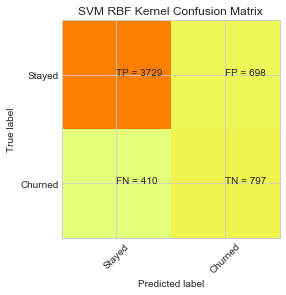

In [82]:
cm = confusion_matrix(y_pred, y)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Stayed','Churned']
plt.title('SVM RBF Kernel Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TP','FP'], ['FN', 'TN']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

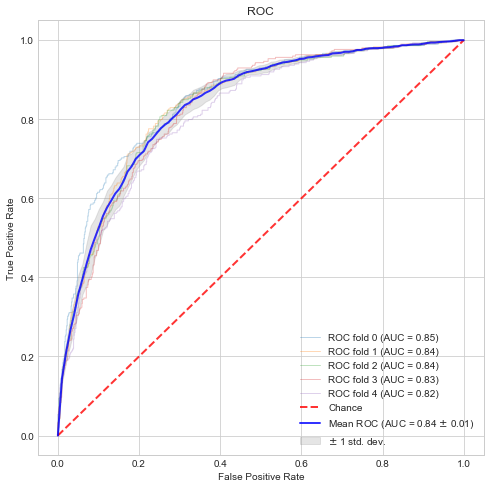

In [83]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = SVC(kernel="rbf",C=10, gamma=0.001, probability=True,random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 8))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [84]:
# rows that were wrong
df_missed  = df.iloc[np.where(y_pred != y)[0]]

Trying to add principal components to data. Using principal componenets alone is shown in presentation pdfs included in repo (achieves 1-2% lower accuracy than the normal features)

In [85]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.22590711, 0.14914955, 0.13587374])

In [86]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
finalDf = pd.concat([principalDf, df[['Churn']]], axis = 1)

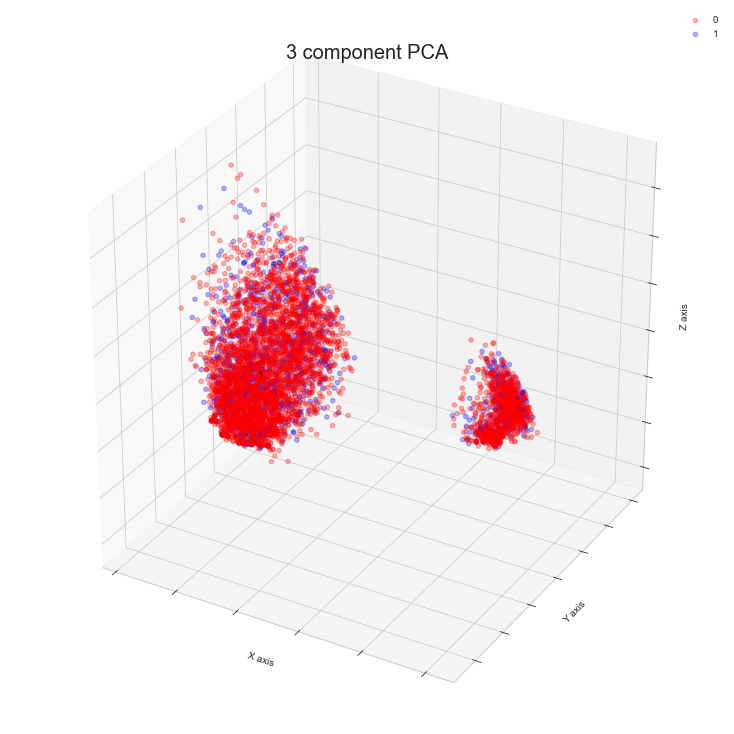

In [87]:
def PCA_2D_graphs(overlay):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0,1]
    colours = ['r', 'y']
    for target, colour in zip(targets,colours):
        indicesToKeep = finalDf['Churn'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = colour
                   ,  alpha=0.3,label=str(target))
    for i in range(principalDf.shape[0]):
        if i%50==0:
            ax.text(finalDf.loc[i, 'principal component 1']
                   , finalDf.loc[i, 'principal component 2'], round(df.loc[i,overlay],2))
    ax.legend(targets)
    ax.grid()

def PCA_3D_graphs(overlay):
    fig = plt.figure(1, figsize=(11, 11))
    plt.clf()
    cols = finalDf.columns
    ax = Axes3D(fig)
#     for i in range(0,X.shape[0]):
#         ax.text3D(cols[i, 0], cols[i, 1],cols[i, 2], "  "+str(i),fontsize='x-small')
#     #Reorder the labels to have colors matching the cluster result

    targets = [0,1]
    colours = ['r', 'b']
    for target, colour in zip(targets,colours):
        indicesToKeep = finalDf['Churn'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                ,finalDf.loc[indicesToKeep, 'principal component 3']
                   , c = colour
                   ,  alpha=0.3,label=str(target))

    for i in range(cols.shape[0]):
        if i%30==0:
            ax.text(finalDf.loc[i, 'principal component 1']
                   , finalDf.loc[i, 'principal component 2']
                ,finalDf.loc[i, 'principal component 3'], round(df.loc[i,'PhoneService_No'],2))
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_xlabel('X axis')
    plt.legend(targets)
    ax.set_title('3 component PCA', fontsize = 20)

    plt.show()
    
PCA_2D_graphs('PhoneService_No')

PCA_3D_graphs('PhoneService_No')

In [88]:
# add in prediction with just principal components aloen 

In [89]:
new_df = pd.merge(principalDf, df, left_index=True, right_index=True)
new_df.head()

principal component 1  principal component 2  principal component 3  \
0              -0.622843              -0.642760               0.154591   
1              -0.120591              -1.064828              -0.758891   
2               0.201005               0.169396              -1.060041   
3              -0.571441               0.568368               0.259166   
4               0.010193              -1.881539              -0.544218   

   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG       1              0        1           0       1   
1  5575-GNVDE       0              0        0           0      34   
2  3668-QPYBK       0              0        0           0       2   
3  7795-CFOCW       0              0        0           0      45   
4  9237-HQITU       1              0        0           0       2   

   PaperlessBilling     ...      StreamingMovies_No internet service  \
0                 1     ...                                        0   
1                 0     ...                                        0   
2                 1     ...                                        0   
3                 0     ...                                        0   
4                 1     ...                                        0   

   StreamingMovies_Yes  Contract_Month-to-month  Contract_One year  \
0                    0                        1                  0   
1                    0                        0                  1   
2                    0                        1                  0   
3                    0                        0                  1   
4                    0                        1                  0   

   Contract_Two year  PaymentMethod_Bank transfer (automatic)  \
0                  0                                        0   
1                  0                                        0   
2                  0                                        0   
3                  0                                        1   
4                  0                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  extra_fees  
0                           0        0.00  
1                           1      -46.80  
2                           1        0.45  
3                           0      -62.75  
4                           0       10.25  

[5 rows x 47 columns]

In [90]:
X = new_df[new_df.columns.difference(['Churn', 'customerID'])].values
y = new_df["Churn"].values
print("FULL")
print(X.shape)
print(y.shape)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = RobustScaler()
X = scaler.fit_transform(X)

FULL
(5634, 45)
(5634,)


In [91]:
baseline_model = SVC(kernel="rbf", gamma='auto')
y_pred = cross_val_predict(baseline_model, X, y, cv=5)
print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

baseline_model.fit(X,y)

Accuracy:  0.8034169070335034

[[3010  579]
 [ 307  611]]

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3317
           1       0.67      0.51      0.58      1190

   micro avg       0.80      0.80      0.80      4507
   macro avg       0.75      0.71      0.73      4507
weighted avg       0.79      0.80      0.79      4507



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [92]:
y_pred = baseline_model.predict(X_test)

print("Accuracy: ",accuracy_score(y_pred, y_test))
print()
print(confusion_matrix(y_pred, y_test))
print()
print(classification_report(y_test,y_pred))



Accuracy:  0.735581188997338

[[829 298]
 [  0   0]]

              precision    recall  f1-score   support

           0       0.74      1.00      0.85       829
           1       0.00      0.00      0.00       298

   micro avg       0.74      0.74      0.74      1127
   macro avg       0.37      0.50      0.42      1127
weighted avg       0.54      0.74      0.62      1127



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Adding three principal components to the dataset increases accuracy by %0.01

### Feature Importances

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


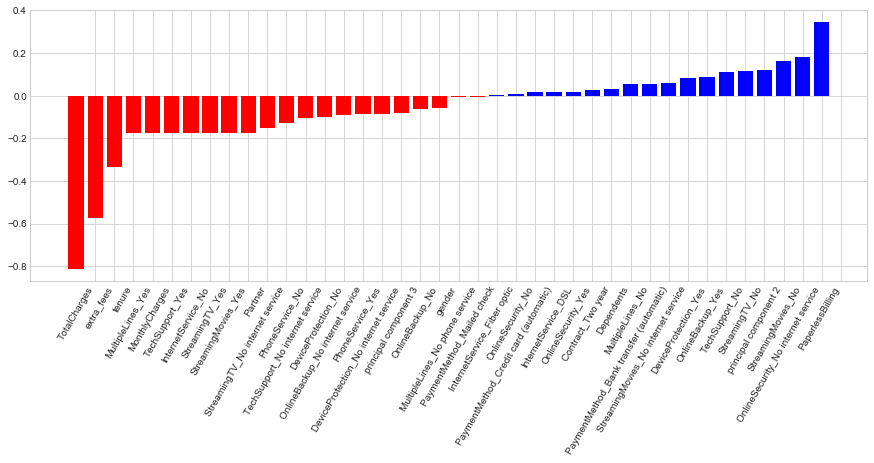

In [93]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()


final_model = LinearSVC(C=10)
final_model.fit(X,y)
names = list(new_df.columns[1:])
names.remove('Churn')
plot_coefficients(final_model,names)

Although adding in the first three principal components slightly increased the classification accuracy, only pc2 shows up as being important for prediction. The coefficents from the hyperplane in linear svm are used to determine feature importance. As expected TotalCharges, extra_fees, tenure and MonthlyCharges are important for predicting churn. It is not obvious why paperlessBilling is important. 

### Recursive Feature Elimination with Cross Validation

Optimal number of features : 14


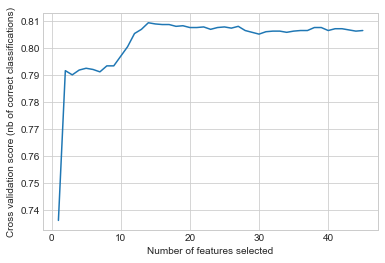

In [94]:
# Create the RFE object and compute a cross-validated score.
# ISSUE convergence warning - increased iterations and use standerscaler?? - set dual= False
svc = LinearSVC(C=100,max_iter=1000, dual=False)
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5),
              scoring='accuracy', verbose=0)
scaler = StandardScaler()
X = scaler.fit_transform(X)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [95]:
# need to select features using mask - support_
cols = new_df.columns
print(rfecv.ranking_)
print(rfecv.support_)

columns_selected = [cols[i] for i,x in enumerate(rfecv.support_) if x]

[ 1 15 16 13 29  5  7  1  1  4  1 10 11  1 19  2 18 21  1 22  1 32 26 27
  1 25 17  6  9 12  1  1  8  1  1  1  3 31 14 30 20 23 24 28  1]
[ True False False False False False False  True  True False  True False
 False  True False False False False  True False  True False False False
  True False False False False False  True  True False  True  True  True
 False False False False False False False False  True]


In [96]:
columns_selected

['principal component 1',
 'Dependents',
 'tenure',
 'MonthlyCharges',
 'PhoneService_No',
 'InternetService_DSL',
 'InternetService_No',
 'OnlineBackup_No',
 'TechSupport_No',
 'TechSupport_No internet service',
 'StreamingTV_No',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'PaymentMethod_Electronic check']

results with above features 

In [97]:
# not including churn or customer id
X = new_df[columns_selected].values
y = new_df["Churn"].values
print("FULL")
print(X.shape)
print(y.shape)


X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = RobustScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)
print("X Train: ", X.shape)
print("y Train: ",y.shape)
print("X Test: ",X_test.shape)
print("y Test: ",y_test.shape)

FULL
(5634, 14)
(5634,)
X Train:  (4507, 14)
y Train:  (4507,)
X Test:  (1127, 14)
y Test:  (1127,)


In [98]:
rbf_model = SVC(kernel="rbf",gamma='auto')
y_pred = cross_val_predict(rbf_model, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

Accuracy:  0.7925449301087197

[[3033  651]
 [ 284  539]]

              precision    recall  f1-score   support

           0       0.82      0.91      0.87      3317
           1       0.65      0.45      0.54      1190

   micro avg       0.79      0.79      0.79      4507
   macro avg       0.74      0.68      0.70      4507
weighted avg       0.78      0.79      0.78      4507



using almost 1/4 of the original features an accuracy of 79% can be reached  with rbf kernel

### SMOTE with dataset + 3 prinicpal components

In [111]:
from imblearn.over_sampling import SMOTE 

X = new_df[new_df.columns.difference(['Churn', 'customerID'])].values
y = new_df["Churn"].values
print("FULL")
print(X.shape)
print(y.shape)


X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

scaler = RobustScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)


print("X Train: ", X.shape)
print("y Train: ",y.shape)
print("X Test: ",X_test.shape)
print("y Test: ",y_test.shape)

# only applying smote to training

FULL
(5634, 45)
(5634,)
X Train:  (6634, 45)
y Train:  (6634,)
X Test:  (1127, 45)
y Test:  (1127,)


In [112]:
# train
rbf_model = SVC(kernel="rbf",gamma='auto')
y_pred = cross_val_predict(rbf_model, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

rbf_model.fit(X,y)

Accuracy:  0.8025324088031354

[[2592  585]
 [ 725 2732]]

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      3317
           1       0.79      0.82      0.81      3317

   micro avg       0.80      0.80      0.80      6634
   macro avg       0.80      0.80      0.80      6634
weighted avg       0.80      0.80      0.80      6634



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [113]:
# test

y_pred = rbf_model.predict(X_test) 

print("Accuracy: ",accuracy_score(y_pred, y_test))
print()
print(confusion_matrix(y_pred, y_test))
print()
print(classification_report(y_test, y_pred))

Accuracy:  0.7480035492457853

[[648 103]
 [181 195]]

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       829
           1       0.52      0.65      0.58       298

   micro avg       0.75      0.75      0.75      1127
   macro avg       0.69      0.72      0.70      1127
weighted avg       0.77      0.75      0.76      1127



Test set has higher accuracy with smote than without (%3)!

### Random Forest 

In [114]:
from sklearn.ensemble import RandomForestClassifier

In [115]:
# smote was used on train
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_pred = cross_val_predict(clf, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

clf.fit(X,y)

Accuracy:  0.8477539945734097

[[2930  623]
 [ 387 2694]]

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3317
           1       0.87      0.81      0.84      3317

   micro avg       0.85      0.85      0.85      6634
   macro avg       0.85      0.85      0.85      6634
weighted avg       0.85      0.85      0.85      6634



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [116]:
y_pred = clf.predict(X_test) 

print("Accuracy: ",accuracy_score(y_pred, y_test))
print()
print(confusion_matrix(y_pred, y_test))
print()
print(classification_report(y_test, y_pred))

Accuracy:  0.7755102040816326

[[734 158]
 [ 95 140]]

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       829
           1       0.60      0.47      0.53       298

   micro avg       0.78      0.78      0.78      1127
   macro avg       0.71      0.68      0.69      1127
weighted avg       0.76      0.78      0.77      1127



In [120]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = new_df[new_df.columns.difference(['Churn', 'customerID'])].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

importance
Contract_Month-to-month           0.072591
tenure                            0.068516
TotalCharges                      0.062028
TechSupport_No                    0.062015
OnlineSecurity_No                 0.059511
PaymentMethod_Electronic check    0.055328
MonthlyCharges                    0.046171
principal component 1             0.044450
extra_fees                        0.043233
principal component 3             0.042258

Random Forest does better than SVM and has some overlap in important features